# Veille Technologique - Modele CNN ResNet50 vs Vision Transformers (ViT)

## Imports et config

In [1]:
# %pip install timm

In [2]:
import os
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from torch import nn, optim
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device: cpu


## Chargement du dataset

In [3]:
SOURCES_PATH = "../Sources/"
CSV_FILE = "flipkart_com-ecommerce_sample_1050.csv"
CSV_FILEPATH = SOURCES_PATH + CSV_FILE
IMG_ROOT = Path(SOURCES_PATH + "Images/")

df = pd.read_csv(CSV_FILEPATH)

print('DataSet Shape = {}'.format(df.shape))
print('DataSet Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))

DataSet Shape = (1050, 15)
DataSet Memory Usage = 0.11 MB


#### Je cree ma colonne avec mes 7 categories

In [4]:
df['category_simple'] = df['product_category_tree'].apply(lambda x: x.split(' >> ')[0].split('["')[1])

#### On conserve uniquement les lignes avec des images existantes, mesure de securite

In [5]:
def img_exists(row):
    return (IMG_ROOT / str(row["image"])).exists()

In [6]:
df['img_path'] = df['image'].apply(lambda x: IMG_ROOT / str(x))
print("Nombre total de lignes/images:", len(df))

Nombre total de lignes/images: 1050


#### Encodage des labels

In [7]:
classes = sorted(df['category_simple'].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

In [8]:
df['label'] = df['category_simple'].map(class_to_idx)
num_classes = len(classes)
print("Classes:", classes)

Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


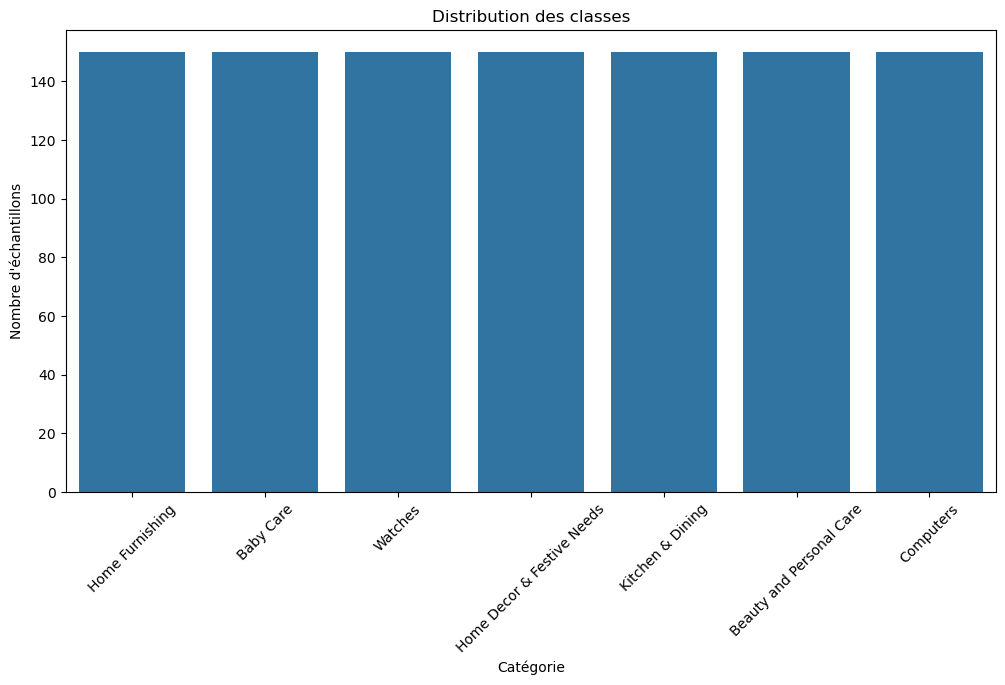

In [9]:
# barplot des classes
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='category_simple', order=df['category_simple'].value_counts().index)
plt.title('Distribution des classes')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'échantillons')
plt.xticks(rotation=45)
plt.show()

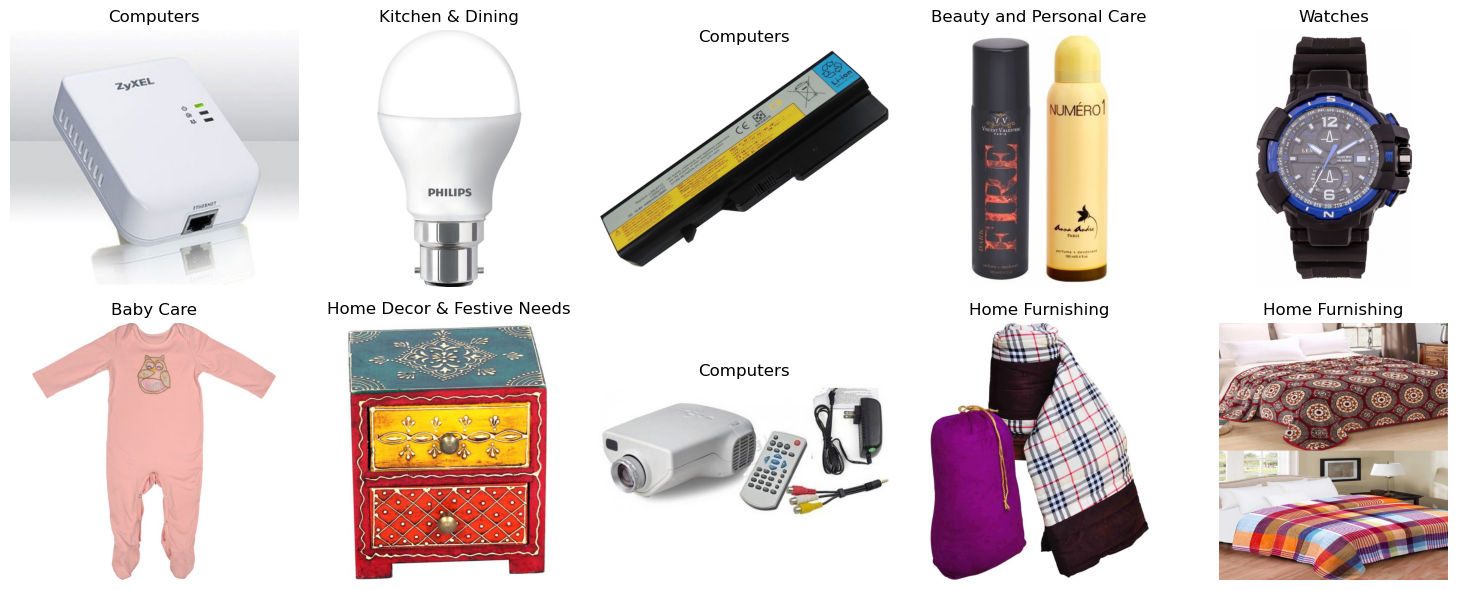

In [10]:
# Visualisation de quelques images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sampled_df = df.sample(10, random_state=SEED).reset_index(drop=True)
for i, ax in enumerate(axes.flatten()):
    img_path = sampled_df.loc[i, 'img_path']
    label = sampled_df.loc[i, 'category_simple']
    image = Image.open(img_path).convert('RGB')
    ax.imshow(image)
    ax.set_title(label)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Split train / val / test

#### Stratifier sur la categorie

In [11]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=SEED
)

In [12]:
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.70,
    stratify=temp_df["label"],
    random_state=SEED
)

### Le jeu de 1050 images est découpé en trois sous ensembles disjoints :
#### Entraînement : train = 70%, temp = 30%
#### Validation : temp → val = 30% de 30% = 9%
#### Test : temp → test = 70% de 30% = 21%


In [13]:
len(train_df), len(val_df), len(test_df)

(735, 94, 221)

## Dataset PyTorch + data augmentation

In [14]:
IMG_SIZE = 224

In [15]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

#### Class pour les images

In [16]:
class FlipkartImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['img_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label

In [17]:
train_dataset = FlipkartImageDataset(train_df, transform=train_transform)
val_dataset   = FlipkartImageDataset(val_df, transform=eval_transform)
test_dataset  = FlipkartImageDataset(test_df, transform=eval_transform)
# Train "clean" = mêmes images que le train, mais sans data augmentation
train_dataset_clean = FlipkartImageDataset(train_df, transform=eval_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
train_loader_clean  = DataLoader(train_dataset_clean, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

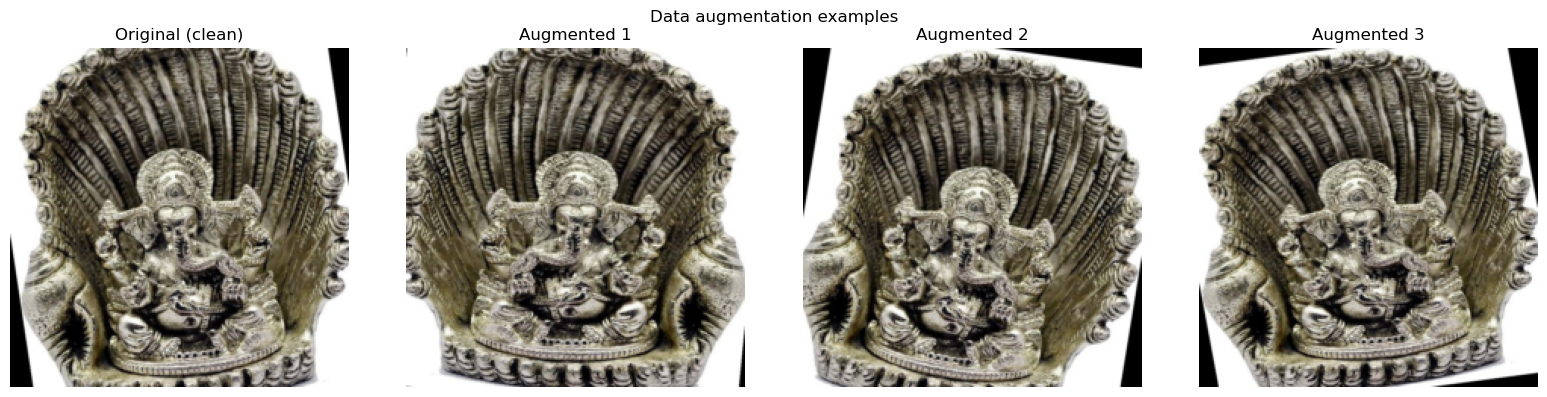

In [18]:
# affiche 1 image originale et 3 versions transformées crop/rotation/flip grace au train_transform
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    x = tensor.clone().detach().cpu()
    for c, (m, s) in enumerate(zip(mean, std)):
        x[c] = x[c] * s + m
    x = torch.clamp(x, 0, 1)
    return x.permute(1, 2, 0).numpy()


def show_augmentations_from_dataset(dataset, idx=0, n_aug=3, title="Data augmentation examples"):
   
    img_path = dataset.df.iloc[idx]['img_path']

    img = Image.open(img_path).convert("RGB")

    orig_tensor = train_transform(img)
    orig_np = denormalize(orig_tensor)

    aug_nps = []
    for _ in range(n_aug):
        aug_tensor = train_dataset.transform(img)
        aug_nps.append(denormalize(aug_tensor))

    cols = 1 + n_aug
    plt.figure(figsize=(4 * cols, 4))
    plt.subplot(1, cols, 1)
    plt.imshow(orig_np)
    plt.title("Original (clean)")
    plt.axis("off")

    for i in range(n_aug):
        plt.subplot(1, cols, i + 2)
        plt.imshow(aug_nps[i])
        plt.title(f"Augmented {i+1}")
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_augmentations_from_dataset(train_dataset, idx=0, n_aug=3, title="Data augmentation examples")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


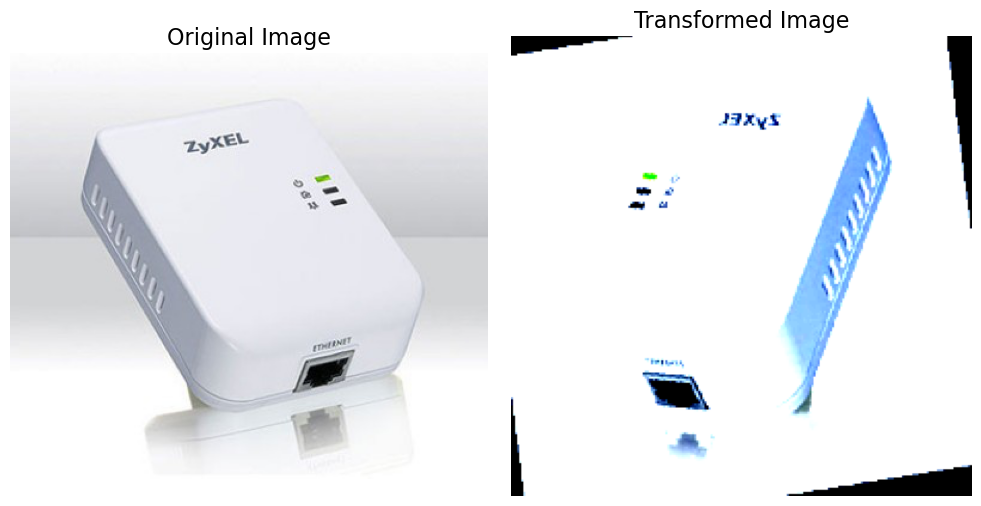

In [19]:
def show_original_and_transformed_image(df, train_transform, SEED):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sample_img_path = df.sample(1, random_state=SEED).iloc[0]['img_path']
    original_img = Image.open(sample_img_path).convert("RGB")
    orig_tensor = train_transform(original_img)
    axes[0].imshow(original_img)
    axes[0].axis('off')
    axes[0].set_title('Original Image', fontsize=16)
    axes[1].imshow(orig_tensor.permute(1, 2, 0).numpy())
    axes[1].axis('off')
    axes[1].set_title('Transformed Image', fontsize=16)
    plt.tight_layout()
    plt.show()
show_original_and_transformed_image(df, train_transform, SEED)

## Fonctions utilitaires pour l'entrainement et l'evaluation

In [20]:
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_loss(criterion, logits, y_a, y_b, lam):
    return lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)

In [21]:
def train_one_epoch(model, loader, criterion, optimizer, log_every=20, mixup_alpha=0.4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        if mixup_alpha and mixup_alpha > 0:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

        optimizer.zero_grad()
        outputs = model(images)

        if mixup_alpha and mixup_alpha > 0:
            loss = mixup_loss(criterion, outputs, y_a, y_b, lam)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if i % log_every == 0:
            print(f"batch {i}/{len(loader)} | loss={loss.item():.3f} | acc={(correct/total):.3f}")

    return running_loss / len(loader.dataset), correct / total

In [22]:
@torch.inference_mode()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

#### Visualisations

In [23]:
def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss
    axes[0].plot(epochs, history["train_loss"], label="Train (aug)")
    axes[0].plot(epochs, history["val_loss"],   label="Val")
    if "train_clean_loss" in history and len(history["train_clean_loss"]) == len(history["train_loss"]):
        axes[0].plot(epochs, history["train_clean_loss"], label="Train (clean)")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    # Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train (aug)")
    axes[1].plot(epochs, history["val_acc"],   label="Val")
    if "train_clean_acc" in history and len(history["train_clean_acc"]) == len(history["train_acc"]):
        axes[1].plot(epochs, history["train_clean_acc"], label="Train (clean)")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## Modele CNN Baseline : ResNet50

In [24]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

#### On remplace la derniere couche FC par notre tete et on gele le backbone

In [25]:
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet = resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

In [27]:
EPOCHS = 15
best_val_acc = 0.0
history_resnet = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

In [28]:
patience = 5  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(resnet, val_loader, criterion)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(resnet, train_loader_clean, criterion)

    history_resnet["train_loss"].append(train_loss)
    history_resnet["train_clean_loss"].append(train_clean_loss)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["train_acc"].append(train_acc)
    history_resnet["train_clean_acc"].append(train_clean_acc)
    history_resnet["val_acc"].append(val_acc)

    print(f"[ResNet] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f} | "
          f"Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    # Logique d'early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), "resnet50_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=1.971 | acc=0.062
batch 20/46 | loss=1.917 | acc=0.146


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.813 | acc=0.186


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 01 | Train loss=1.896, acc=0.190 | Val loss=1.817, acc=0.489 | Train(clean) loss=1.830, acc=0.427
batch 0/46 | loss=1.850 | acc=0.375
batch 20/46 | loss=1.820 | acc=0.318


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.673 | acc=0.337


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 02 | Train loss=1.785, acc=0.354 | Val loss=1.690, acc=0.702 | Train(clean) loss=1.705, acc=0.664
batch 0/46 | loss=1.681 | acc=0.688


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.799 | acc=0.455
batch 40/46 | loss=1.688 | acc=0.425


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 03 | Train loss=1.679, acc=0.431 | Val loss=1.592, acc=0.755 | Train(clean) loss=1.601, acc=0.740
batch 0/46 | loss=1.670 | acc=0.875
batch 20/46 | loss=1.675 | acc=0.512
batch 40/46 | loss=1.569 | acc=0.485


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 04 | Train loss=1.594, acc=0.495 | Val loss=1.496, acc=0.777 | Train(clean) loss=1.502, acc=0.776
batch 0/46 | loss=1.485 | acc=0.125


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.545 | acc=0.378
batch 40/46 | loss=1.510 | acc=0.425


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 05 | Train loss=1.503, acc=0.410 | Val loss=1.412, acc=0.787 | Train(clean) loss=1.413, acc=0.788
batch 0/46 | loss=1.334 | acc=0.750


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.478 | acc=0.420
batch 40/46 | loss=1.369 | acc=0.431


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 06 | Train loss=1.449, acc=0.429 | Val loss=1.377, acc=0.798 | Train(clean) loss=1.376, acc=0.801
batch 0/46 | loss=1.380 | acc=0.812
batch 20/46 | loss=1.602 | acc=0.506
batch 40/46 | loss=1.514 | acc=0.489


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 07 | Train loss=1.425, acc=0.480 | Val loss=1.318, acc=0.809 | Train(clean) loss=1.318, acc=0.807
batch 0/46 | loss=1.144 | acc=0.812


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.142 | acc=0.506
batch 40/46 | loss=1.336 | acc=0.462


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 08 | Train loss=1.314, acc=0.475 | Val loss=1.224, acc=0.830 | Train(clean) loss=1.225, acc=0.812
batch 0/46 | loss=1.666 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.112 | acc=0.482
batch 40/46 | loss=1.043 | acc=0.532


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 09 | Train loss=1.346, acc=0.537 | Val loss=1.189, acc=0.840 | Train(clean) loss=1.188, acc=0.815
batch 0/46 | loss=1.072 | acc=0.812
batch 20/46 | loss=1.495 | acc=0.583


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.182 | acc=0.521


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 10 | Train loss=1.263, acc=0.513 | Val loss=1.143, acc=0.840 | Train(clean) loss=1.140, acc=0.822
batch 0/46 | loss=0.879 | acc=0.250
batch 20/46 | loss=1.547 | acc=0.521


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.116 | acc=0.486


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 11 | Train loss=1.234, acc=0.498 | Val loss=1.099, acc=0.840 | Train(clean) loss=1.099, acc=0.818
batch 0/46 | loss=1.148 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.080 | acc=0.485
batch 40/46 | loss=1.070 | acc=0.454


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 12 | Train loss=1.196, acc=0.475 | Val loss=1.021, acc=0.840 | Train(clean) loss=1.017, acc=0.822
batch 0/46 | loss=1.292 | acc=0.812


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.201 | acc=0.408
batch 40/46 | loss=0.783 | acc=0.463


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 13 | Train loss=1.129, acc=0.449 | Val loss=1.009, acc=0.840 | Train(clean) loss=1.002, acc=0.822
batch 0/46 | loss=1.151 | acc=0.312


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.041 | acc=0.426
batch 40/46 | loss=0.661 | acc=0.477


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 14 | Train loss=1.167, acc=0.476 | Val loss=0.983, acc=0.851 | Train(clean) loss=0.980, acc=0.824
batch 0/46 | loss=1.424 | acc=0.688
batch 20/46 | loss=0.954 | acc=0.595
batch 40/46 | loss=1.385 | acc=0.578


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 15 | Train loss=1.077, acc=0.573 | Val loss=0.945, acc=0.851 | Train(clean) loss=0.935, acc=0.837


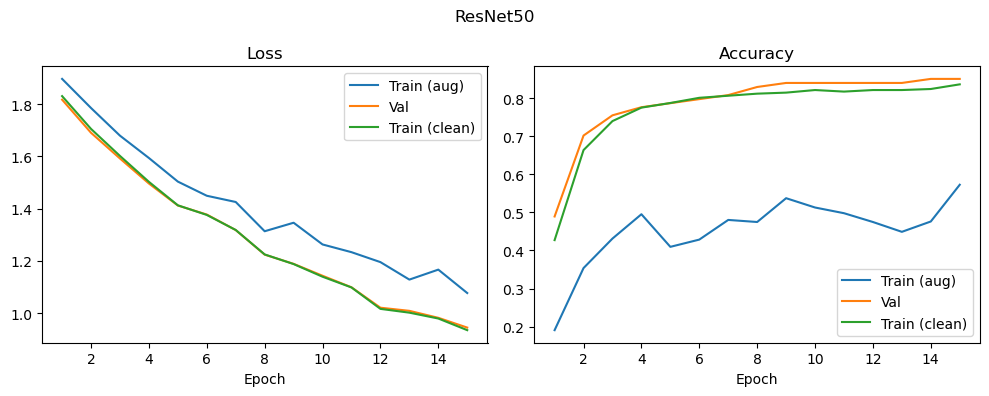

In [29]:
plot_history(history_resnet, title="ResNet50")

## Vision Transformer (ViT-B/16)

In [30]:
vit_base = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)
vit_base = vit_base.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.AdamW(vit_base.parameters(), lr=2e-5, weight_decay=1e-4)

patience = 3  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

EPOCHS_VIT = 15
best_val_acc_vit = 0.0
history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_VIT + 1):
    train_loss, train_acc = train_one_epoch(vit_base, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_base, val_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_base, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f} | "
          f"Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    if val_acc > best_val_acc_vit:
        best_val_acc_vit = val_acc
        torch.save(vit_base.state_dict(), "vit_base_patch16_224_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=2.601 | acc=0.062


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.383 | acc=0.271
batch 40/46 | loss=0.859 | acc=0.393


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 01 | Train loss=1.368, acc=0.401 | Val loss=0.529, acc=0.862 | Train(clean) loss=0.477, acc=0.891
batch 0/46 | loss=0.678 | acc=0.188
batch 20/46 | loss=0.189 | acc=0.646


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.618 | acc=0.518


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 02 | Train loss=0.773, acc=0.520 | Val loss=0.406, acc=0.904 | Train(clean) loss=0.281, acc=0.939
batch 0/46 | loss=1.033 | acc=0.312
batch 20/46 | loss=0.795 | acc=0.497
batch 40/46 | loss=0.405 | acc=0.506


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 03 | Train loss=0.678, acc=0.525 | Val loss=0.347, acc=0.883 | Train(clean) loss=0.162, acc=0.971
batch 0/46 | loss=0.468 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.446 | acc=0.679
batch 40/46 | loss=0.163 | acc=0.668


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 04 | Train loss=0.525, acc=0.653 | Val loss=0.300, acc=0.894 | Train(clean) loss=0.105, acc=0.985
batch 0/46 | loss=0.088 | acc=0.125
batch 20/46 | loss=0.307 | acc=0.613


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.087 | acc=0.643


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 05 | Train loss=0.501, acc=0.635 | Val loss=0.306, acc=0.894 | Train(clean) loss=0.071, acc=0.993
Early stopping après 5 epochs. La précision de la validation ne s'est pas améliorée pour 3 epochs consécutifs.


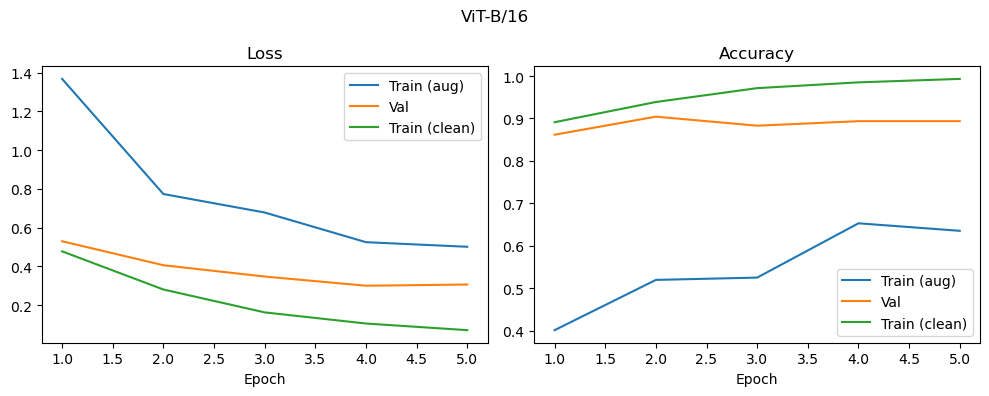

In [31]:
plot_history(history_vit, title="ViT-B/16")

## Évaluation finale sur le test set

ResNet50 - Test loss=1.069, acc=0.801
                            precision    recall  f1-score   support

                 Baby Care       0.72      0.74      0.73        31
  Beauty and Personal Care       0.88      0.74      0.81        31
                 Computers       0.72      0.88      0.79        32
Home Decor & Festive Needs       0.80      0.75      0.77        32
           Home Furnishing       0.79      0.81      0.80        32
          Kitchen & Dining       0.85      0.74      0.79        31
                   Watches       0.88      0.94      0.91        32

                  accuracy                           0.80       221
                 macro avg       0.81      0.80      0.80       221
              weighted avg       0.81      0.80      0.80       221

ViT-B/16 - Test loss=0.528, acc=0.855
                            precision    recall  f1-score   support

                 Baby Care       0.93      0.81      0.86        31
  Beauty and Personal Care       0.9

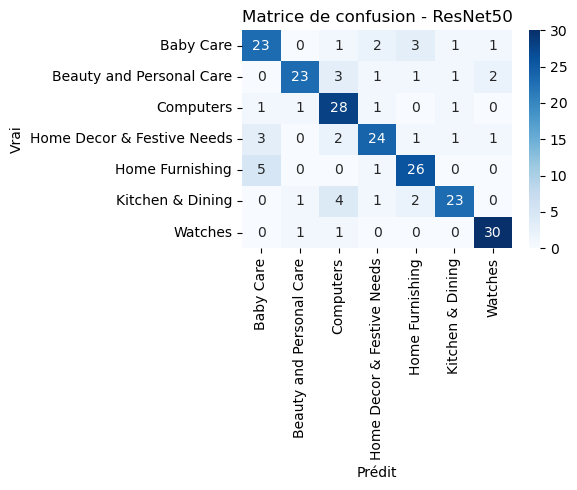

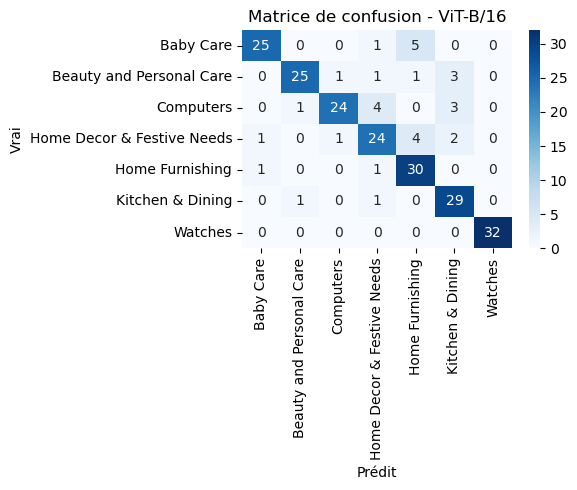

In [32]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit_base.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit_base, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")

## Phase d'amelioration du ViT

### Phase 1

In [34]:
vit_phase1 = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,        # dropout
    drop_path_rate=0.1    # stochastic depth
).to(device)

In [35]:
# on freeze tout
for p in vit_phase1.parameters():
    p.requires_grad = False

# on degele la head et le classifier
for name, p in vit_phase1.named_parameters():
    if "head" in name:
        p.requires_grad = True

criterion_vit = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_vit = optim.AdamW(
    filter(lambda p: p.requires_grad, vit_phase1.parameters()),
    lr=1e-3,
    weight_decay=0.05
)

EPOCHS_PHASE1 = 5

### Boucle d'entrainment phase 1

In [36]:
best_val_loss = float("inf")

history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE1 + 1):
    train_loss, train_acc = train_one_epoch(vit_phase1, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_phase1, val_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_phase1, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Phase 1 - Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f} | Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit_phase1.state_dict(), "vit_phase1_best.pth")

batch 0/46 | loss=2.073 | acc=0.125
batch 20/46 | loss=1.796 | acc=0.315


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.588 | acc=0.349


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 01 | Train loss=1.584, acc=0.380 | Val loss=0.935, acc=0.809 | Train(clean) loss=0.888, acc=0.830
batch 0/46 | loss=0.955 | acc=0.938


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.384 | acc=0.613
batch 40/46 | loss=1.063 | acc=0.607


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 02 | Train loss=1.187, acc=0.604 | Val loss=0.879, acc=0.830 | Train(clean) loss=0.789, acc=0.872
batch 0/46 | loss=0.768 | acc=0.812
batch 20/46 | loss=0.775 | acc=0.452


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.612 | acc=0.570


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 03 | Train loss=1.121, acc=0.550 | Val loss=0.839, acc=0.830 | Train(clean) loss=0.732, acc=0.902
batch 0/46 | loss=0.894 | acc=0.938


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.698 | acc=0.405
batch 40/46 | loss=0.880 | acc=0.434


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 04 | Train loss=1.088, acc=0.453 | Val loss=0.791, acc=0.851 | Train(clean) loss=0.689, acc=0.927
batch 0/46 | loss=1.089 | acc=0.688
batch 20/46 | loss=1.016 | acc=0.577


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (90993672 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.745 | acc=0.604


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 1 - Epoch 05 | Train loss=1.140, acc=0.616 | Val loss=0.799, acc=0.883 | Train(clean) loss=0.685, acc=0.922


In [37]:
vit_phase1.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))

<All keys matched successfully>

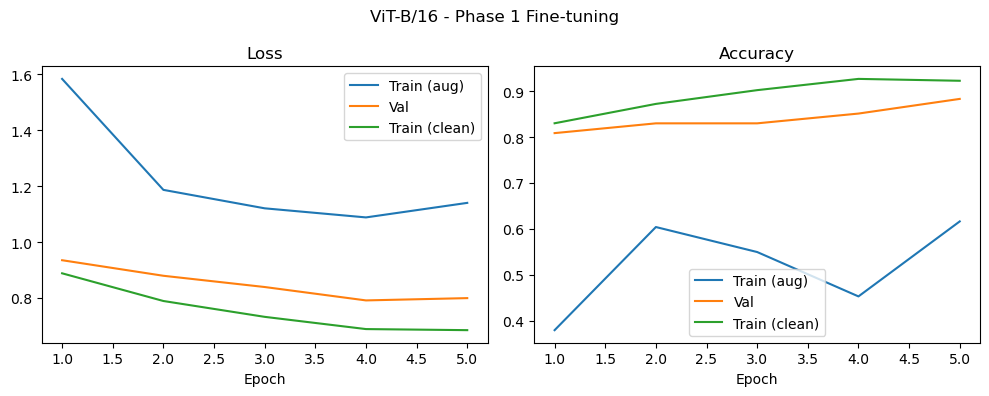

In [38]:
plot_history(history_vit, title="ViT-B/16 - Phase 1 Fine-tuning")

### Phase 2

In [41]:
vit_phase2 = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,        # dropout
    drop_path_rate=0.1    # stochastic depth
).to(device)

In [42]:
# on degele head + derniers blocks
for name, p in vit_phase2.named_parameters():
    if ("blocks.10" in name) or ("blocks.11" in name) or ("head" in name) or ("norm" in name):
        p.requires_grad = True

# LR plus bas pour backbone, plus haut pour head
backbone_params = []
head_params = []

for name, p in vit_phase2.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_vit = optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5},
        {"params": head_params, "lr": 2e-4},
    ],
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vit, mode="min", factor=0.5, patience=2
)

EPOCHS_PHASE2 = 10

### Boucle d'entrainement phase 2

In [43]:
patience = 5
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0

history_vit = {"train_loss": [], "train_clean_loss": [], "val_loss": [], "train_acc": [], "train_clean_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE2 + 1):
    train_loss, train_acc = train_one_epoch(vit_phase2, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit_phase2, val_loader, criterion_vit)
    # accuracy sur train sans augmentation
    train_clean_loss, train_clean_acc, _, _ = evaluate(vit_phase2, train_loader_clean, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["train_clean_loss"].append(train_clean_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["train_clean_acc"].append(train_clean_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Phase 2 - Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f} | Train(clean) loss={train_clean_loss:.3f}, acc={train_clean_acc:.3f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        torch.save(vit_phase2.state_dict(), "vit_phase2_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping après {epoch} epochs (val_loss n'améliore plus).")
        break

batch 0/46 | loss=2.124 | acc=0.188
batch 20/46 | loss=1.991 | acc=0.336


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.828 | acc=0.361


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 01 | Train loss=1.484, acc=0.380 | Val loss=0.820, acc=0.830 | Train(clean) loss=0.798, acc=0.875
batch 0/46 | loss=1.019 | acc=0.812
batch 20/46 | loss=1.371 | acc=0.551


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.647 | acc=0.564


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 02 | Train loss=1.110, acc=0.581 | Val loss=0.737, acc=0.894 | Train(clean) loss=0.664, acc=0.914
batch 0/46 | loss=1.467 | acc=0.500
batch 20/46 | loss=0.923 | acc=0.622


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.992 | acc=0.585


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 03 | Train loss=0.963, acc=0.563 | Val loss=0.687, acc=0.915 | Train(clean) loss=0.554, acc=0.969
batch 0/46 | loss=1.279 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.657 | acc=0.488
batch 40/46 | loss=0.914 | acc=0.480


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 04 | Train loss=0.871, acc=0.499 | Val loss=0.708, acc=0.872 | Train(clean) loss=0.532, acc=0.986
batch 0/46 | loss=0.568 | acc=1.000


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.642 | acc=0.625
batch 40/46 | loss=1.226 | acc=0.642


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 05 | Train loss=0.871, acc=0.634 | Val loss=0.780, acc=0.872 | Train(clean) loss=0.545, acc=0.971
batch 0/46 | loss=0.639 | acc=0.938
batch 20/46 | loss=0.859 | acc=0.616


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.381 | acc=0.657


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 06 | Train loss=0.817, acc=0.649 | Val loss=0.760, acc=0.872 | Train(clean) loss=0.498, acc=0.989
batch 0/46 | loss=1.020 | acc=0.812
batch 20/46 | loss=0.684 | acc=0.667
batch 40/46 | loss=0.746 | acc=0.680


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 07 | Train loss=0.847, acc=0.661 | Val loss=0.672, acc=0.904 | Train(clean) loss=0.480, acc=0.997
batch 0/46 | loss=0.894 | acc=0.375


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.817 | acc=0.491
batch 40/46 | loss=0.480 | acc=0.544


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 08 | Train loss=0.772, acc=0.561 | Val loss=0.650, acc=0.926 | Train(clean) loss=0.474, acc=0.997


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 0/46 | loss=0.471 | acc=0.125
batch 20/46 | loss=0.848 | acc=0.449
batch 40/46 | loss=0.480 | acc=0.506


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 09 | Train loss=0.755, acc=0.494 | Val loss=0.684, acc=0.883 | Train(clean) loss=0.467, acc=0.999
batch 0/46 | loss=1.002 | acc=0.875
batch 20/46 | loss=0.832 | acc=0.720


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.478 | acc=0.655


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Phase 2 - Epoch 10 | Train loss=0.764, acc=0.639 | Val loss=0.696, acc=0.883 | Train(clean) loss=0.469, acc=0.999


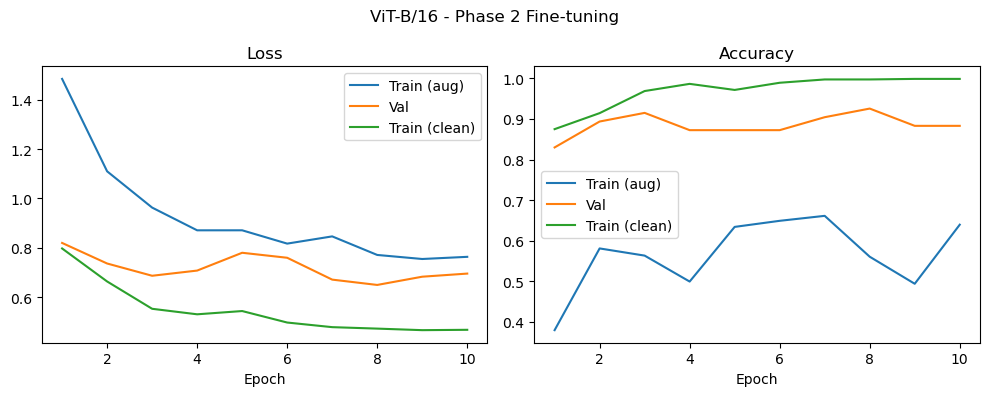

In [44]:
plot_history(history_vit, title="ViT-B/16 - Phase 2 Fine-tuning")

### je charge le meilleur modele

In [45]:
vit_phase2.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))
vit_phase2.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [46]:
test_loss_v2, test_acc_v2, y_true_v2, y_pred_v2 = evaluate(vit_phase2, test_loader, criterion_vit)

print(f"[ViT] Best - Test loss={test_loss_v2:.3f} | acc={test_acc_v2:.3f}")

[ViT] Best - Test loss=0.738 | acc=0.896


                            precision    recall  f1-score   support

                 Baby Care       0.78      0.90      0.84        31
  Beauty and Personal Care       1.00      0.81      0.89        31
                 Computers       0.90      0.84      0.87        32
Home Decor & Festive Needs       0.88      0.91      0.89        32
           Home Furnishing       0.81      0.94      0.87        32
          Kitchen & Dining       0.97      0.90      0.93        31
                   Watches       1.00      0.97      0.98        32

                  accuracy                           0.90       221
                 macro avg       0.90      0.90      0.90       221
              weighted avg       0.90      0.90      0.90       221



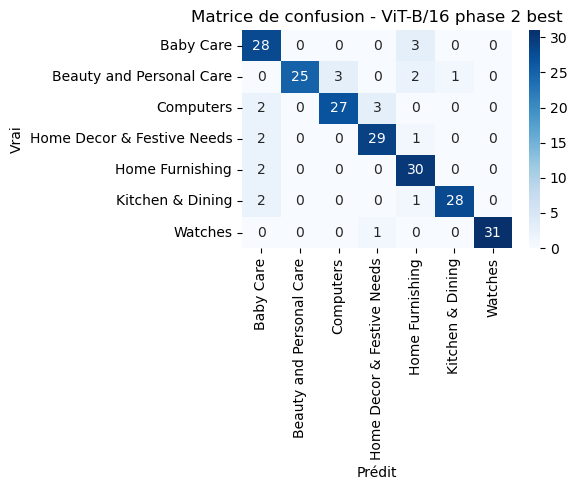

In [47]:
print(classification_report(y_true_v2, y_pred_v2, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_v2, y_pred_v2, "Matrice de confusion - ViT-B/16 phase 2 best")

In [48]:
(y_true_v2 == y_pred_v2).mean()

0.8959276018099548

### Comparatif des modeles ResNet50 / ViT base / ViT phase 2

ResNet50 - Test loss=1.069, acc=0.801
                            precision    recall  f1-score   support

                 Baby Care       0.72      0.74      0.73        31
  Beauty and Personal Care       0.88      0.74      0.81        31
                 Computers       0.72      0.88      0.79        32
Home Decor & Festive Needs       0.80      0.75      0.77        32
           Home Furnishing       0.79      0.81      0.80        32
          Kitchen & Dining       0.85      0.74      0.79        31
                   Watches       0.88      0.94      0.91        32

                  accuracy                           0.80       221
                 macro avg       0.81      0.80      0.80       221
              weighted avg       0.81      0.80      0.80       221

ViT-B/16 - Test loss=0.852, acc=0.855
                            precision    recall  f1-score   support

                 Baby Care       0.93      0.81      0.86        31
  Beauty and Personal Care       0.9

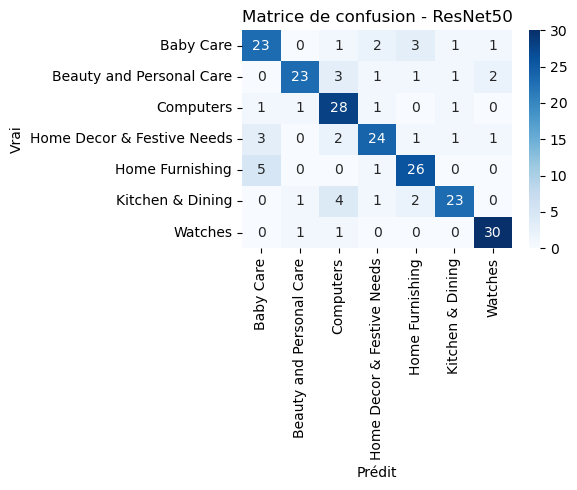

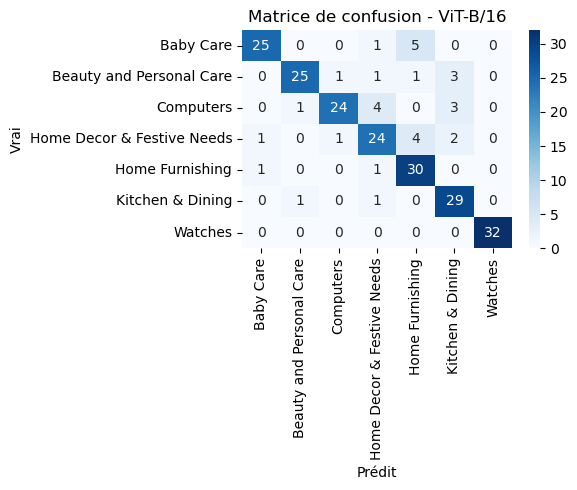

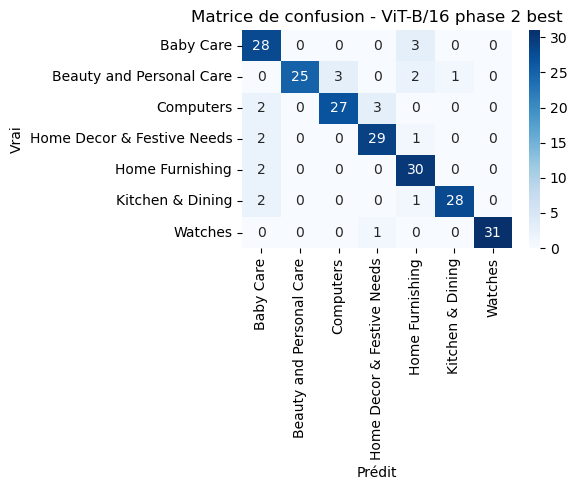

In [49]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit_base.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))
vit_phase2.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit_base, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# ViT Phase 2 best
test_loss_v2, test_acc_v2, y_true_v2, y_pred_v2 = evaluate(vit_phase2, test_loader, criterion_vit)
print(f"ViT-B/16 Phase 2 - Test loss={test_loss_v2:.3f}, acc={test_acc_v2:.3f}")
print(classification_report(y_true_v2, y_pred_v2, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")
plot_confusion(y_true_v2, y_pred_v2, "Matrice de confusion - ViT-B/16 phase 2 best")